# Business Understanding

It is important for city officials to have an overview about their cities' state at all times. One crucial aspect is the safety of all residents.  
Therefore a city must monitor what type of crimes happen when and where. Decisions like where and when to deploy how many police officers need to be based on actual data, as most cities are notoriously tight on human and monetary resources.

This project aims to provide a basic understanding about the crime scene of the City of Chicago

# Data Understanding

## Importing necessary libraries

In [1]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Load initial dataset(s)
The dataset is continiously updated and available at https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2.  
At the time of writing it contains over 7.45 million rows with 22 columns.

For the analysis I have focused on the following features:  
*Date, Primary Type, Arrest, Domestic, Community Area, Year, Latitude & Longitude*

Reasons for excluding other featuers are for example redundant information (*Location*) from other features or simply irrelevance (*Case Number*, *FBI Code*).

Furthermore, a geojson file containing the 77 community areas of Chicago has been used. The data is available at https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

In [2]:
# Only use subset of columns and provide dtype for certain columns to reduce memory size
cols = ['Date', 'Primary Type', 'Arrest', 'Domestic', 'Community Area', 'Year', 'Latitude', 'Longitude']

df = pd.read_csv('./Crimes_-_2001_to_Present.csv', usecols=cols, dtype={'Primary Type': 'category', 'Year': 'int16'}, parse_dates=['Date'])
df.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7451780 entries, 0 to 7451779
Columns: 8 entries, Date to Longitude
dtypes: bool(2), category(1), datetime64[ns](1), float64(3), int16(1)
memory usage: 262.9 MB


In [3]:
df.head()

,Date,Primary Type,Arrest,Domestic,Community Area,Year,Latitude,Longitude
0,2015-09-05 13:30:00,BATTERY,False,True,61.0,2015,41.815117,-87.670000
1,2015-09-04 11:30:00,THEFT,False,False,25.0,2015,41.895080,-87.765400
2,2018-09-01 00:01:00,THEFT,False,True,44.0,2018,NaN,NaN
3,2015-09-05 12:45:00,NARCOTICS,True,False,21.0,2015,41.937406,-87.716650
4,2015-09-05 13:00:00,ASSAULT,False,True,25.0,2015,41.881903,-87.755121


In [4]:
communities = gpd.read_file('./chicago_community_areas.geojson')

# Prepare Data

Before we can start answering our business questions we need to do some changes to prepare the data for actual usage.

First check for missing values

In [5]:
df.isnull().sum()

Date                   0
Primary Type           0
Arrest                 0
Domestic               0
Community Area    613479
Year                   0
Latitude           74929
Longitude          74929
dtype: int64

We see that a that the features *Community Area* as well as *Latitude* and *Longitude* have missing values.  
Since we have the geo data for all community areas, we should be able to fill the missing community area for those records, where latitude and longitude are available.  
Only for those records, where latitude and longitude are missing we will not be able to set a value for community area and therefore drop the row.

In [6]:
df.dropna(subset=['Community Area', 'Latitude', 'Longitude'], how='all', inplace=True)
df[['Community Area', 'Latitude', 'Longitude']].isnull().sum()
# Removed 9203 rows

Community Area    604276
Latitude           65726
Longitude          65726
dtype: int64

Let's check if there are any records where only latitude or only longitude is set

In [7]:
df[(pd.notna(df.Latitude) & pd.isna(df.Longitude)) |  (pd.isna(df.Latitude) & pd.notna(df.Longitude))].shape

(0, 8)

The process of deriving the community area by given latitude and longitude is relatively costly and takes a lot of time. As can be seen below, the vast majority of NaN values for Community Area is from the years 2001 & 2002. To drastically reduce the processing time we remove therefore all crimes from those two years and let our dataset start in the year 2003.
Additionally we will remove the data for 2021, as the dataset ends in November 2021 and certain analysis might get biased with missing data from November & December 2021.

In [8]:
missing_community_areas = df[pd.isna(df['Community Area'])].copy()
missing_community_areas.groupby('Year').size()

Year
2001    477127
2002    126020
2003        43
2004        63
2005        48
2006        44
2007       153
2008       200
2009       196
2010       184
2011       174
2012        22
2013         1
2020         1
dtype: int64

In [9]:
df.drop(df[df.Year <= 2002].index, inplace=True)
# Dropped 963487 rows
df.drop(df[df.Year >= 2021].index, inplace=True)

We define two helper functions to derive the community area from a given pair of latitude and longitude

In [10]:
def get_community_by_coordinates(latitude, longitude):
    """
    INPUT
    latitude - Latitude of a location
    longitude - Longitude of a location
    
    OUTPUT
    Returns a float number representing a community area of Chicago
    """
    community_areas = communities
    point = Point(longitude, latitude)
    polygons = community_areas.geometry
    for polygon in polygons:
        if point.within(polygon):
            return community_areas.area_num_1[community_areas.geometry == polygon].iloc[0]
        
def get_community(area, latitude, longitude):
    """
    INPUT
    area - Float number, representing a community area of Chicago, or NaN
    latitude - Latitude of a location
    longitude - Longitude of a location
    
    OUTPUT
    area - Returns a float number representing a community area of Chicago
    """
    area_number = area
    if pd.isna(area):
        area_number = get_community_by_coordinates(latitude, longitude)
        return area_number
    return area_number

In [11]:
df['Community Area'] = df.apply(lambda row: get_community(row['Community Area'], row['Latitude'], row['Longitude']), axis=1)
df[['Community Area']].isnull().sum()

Community Area    11
dtype: int64

Some rows still have not been assigned a community area. Since the number is very small we drop those rows

In [12]:
df.drop(df[df['Community Area'].isnull()].index, inplace=True)
df[['Community Area']].isnull().sum()

Community Area    0
dtype: int64

By default the value for community area is of type *float*, so we convert it to be *int*. Also the column *area_num_1* in the geo data needs to be converted to *int*

In [13]:
df['Community Area'] = df['Community Area'].astype(int)
communities['area_num_1'] = communities['area_num_1'].astype(int)

Some records have a community area value of 0 which, according to the communities dataset, does not exist, so we remove them from the dataset

In [14]:
df[df['Community Area'] == 0].shape

(70, 8)

In [15]:
df.drop(df[df['Community Area'] == 0].index, inplace=True)

We can drop the columns *Latitude* and *Longitude*

In [16]:
df.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

Finally we extract the month, weekday and hour from the *date* column and assign them to new columns

In [17]:
df['Month'] = pd.DatetimeIndex(df.Date).month
df['Weekday'] = pd.DatetimeIndex(df.Date).day_of_week
df['Hour'] = pd.DatetimeIndex(df.Date).hour

In [18]:
# Save final, cleaned dataset
#df.to_csv('cleaned_dataset.csv')

In [19]:
df.shape

(6289700, 9)

Our final dataset to work with has **6,289,700 rows** and **9 columns**

In [20]:
# Load previously saved, cleaned dataset to skip time consuming data cleaning process
#cols = ['Date', 'Primary Type', 'Arrest', 'Domestic', 'Community Area', 'Year', 'Month', 'Weekday', 'Hour']

#df = pd.read_csv('./cleaned_dataset.csv', usecols=cols, dtype={'Primary Type': 'category', 'Year': 'int16', 'Month': 'int16', 'Weekday': 'int16', 'Hour': 'int16'}, parse_dates=['Date'])
#df.info(verbose=False, memory_usage='deep')

# Data Modeling

For this project we have three business questions we can answer with pure data analysis. For the fourth question we are using a simple machine learning approach to get our results.

## When do crimes in Chicago happen?

The first question we want to answer is whether there are any differences in the total number of crimes for different time scales: Year, Month, Weekday and Hour

In [21]:
yearly_crimes = df.groupby('Year').size()
monthly_crimes = df.groupby('Month').size()
weekday_crimes = df.groupby('Weekday').size()
hour_crimes = df.groupby('Hour').size()

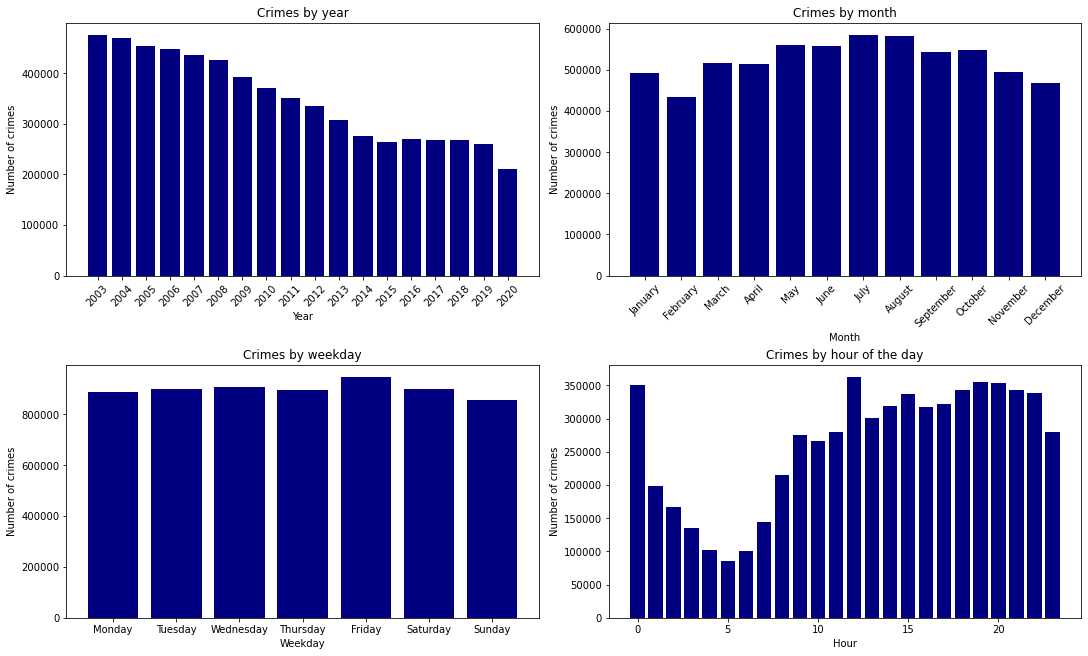

In [22]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(constrained_layout=True)
fig.set_figheight(9)
fig.set_figwidth(15)
plt.subplot(2, 2, 1)
plt.bar(yearly_crimes.index.astype(str), yearly_crimes.values, color='navy')
plt.title('Crimes by year')
plt.xlabel('Year')
plt.ylabel('Number of crimes')
plt.xticks(rotation=45)
plt.subplot(2, 2, 2)
plt.bar(months, monthly_crimes.values, color='navy')
plt.title('Crimes by month')
plt.xlabel('Month')
plt.ylabel('Number of crimes')
plt.xticks(rotation=45)
plt.subplot(2, 2, 3)
plt.bar(weekdays, weekday_crimes.values, color='navy')
plt.title('Crimes by weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of crimes')
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(2, 2, 4)
plt.bar(hour_crimes.index, hour_crimes.values, color='navy')
plt.title('Crimes by hour of the day')
plt.xlabel('Hour')
plt.ylabel('Number of crimes')

plt.show()
#plt.savefig('crimes_seasonality.png', dpi=100)

## What are the top 3 crimes for each community area?

Next we are interested in the most common crimes per community area

In [23]:
comm_crimes_grouped = df.groupby('Community Area')['Primary Type'].value_counts()
comm_crimes_grouped

Community Area                                  
1               THEFT                               20945
                BATTERY                             17662
                CRIMINAL DAMAGE                     11431
                NARCOTICS                            8951
                OTHER OFFENSE                        6480
                                                    ...  
77              NON - CRIMINAL                          0
                HUMAN TRAFFICKING                       0
                NON-CRIMINAL (SUBJECT SPECIFIED)        0
                RITUALISM                               0
                DOMESTIC VIOLENCE                       0
Name: Primary Type, Length: 2772, dtype: int64

In [24]:
def get_geo_data_for_top_n_crime(data_grouped_by_crimes, nth_crime):
    """
    INPUT
    data_grouped_by_crimes - Multiindex series with community area and primary type as index and crime count as value
    nth_crime - The crime rank of interest
    
    OUTPUT
    Returns a dataframe containing the geo data and crime counts for the top nth crime for each community area
    """
    comm_crimes_nth = data_grouped_by_crimes.to_frame('Count').groupby(level=0, as_index=False).nth(nth_crime - 1)
    comm_crimes_nth.index.rename(names=['Community Area', 'Primary Type'], level=[0, 1], inplace=True)
    comm_crimes_nth = comm_crimes_nth.reset_index()
    comm_crimes_nth['Primary Type'] = comm_crimes_nth['Primary Type'].cat.remove_unused_categories()
    
    return communities[['area_num_1', 'geometry']].merge(comm_crimes_nth, how='inner', left_on='area_num_1', right_on='Community Area').drop(columns=['area_num_1'])

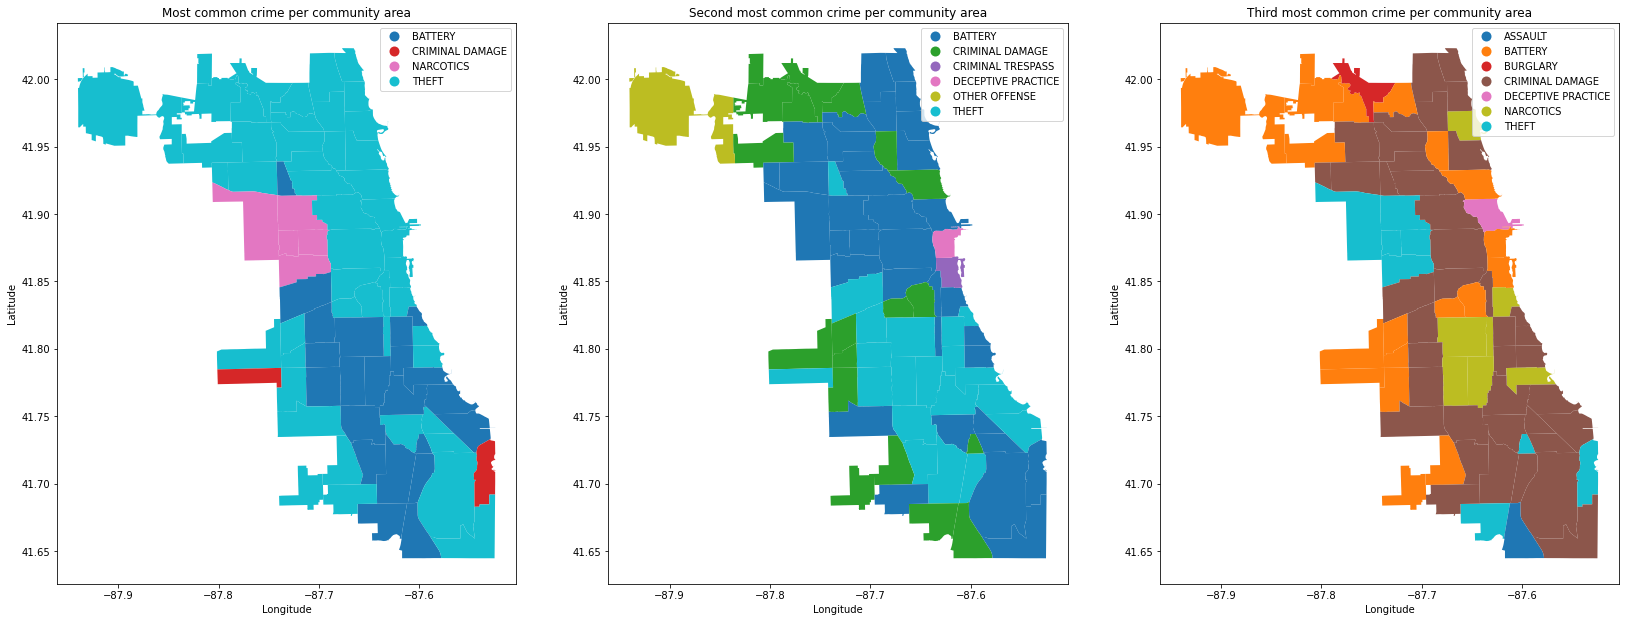

In [25]:
f, axes = plt.subplots(figsize=(28, 20), ncols=3, nrows=1)
titles = {
    1: 'Most common crime per community area',
    2: 'Second most common crime per community area',
    3: 'Third most common crime per community area'
}
for i in range(3):
    crime_geodata = get_geo_data_for_top_n_crime(comm_crimes_grouped, i + 1)
    axes[i].set_title(titles[i + 1])
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    crime_geodata.plot(ax=axes[i], column='Primary Type', categorical=True, legend=True)
#plt.savefig('crimes_per_community_area.png', dpi=100)

## Where do the most crimes happen?

We know that theft and battery are the most common crimes in a lot of community areas. Now we want to see the relative differences between community areas for the top 3 crimes (theft, battery, criminal damage)

In [26]:
comm_crimes = df.groupby('Community Area').size().to_frame('Count')
comm_crimes

,Count
Community Area,
1,95803
2,79581
3,90642
4,44300
5,37095
...,...
73,74925
74,14057
75,50294


In [27]:
def get_geo_data_for_crime(crime):
    """
    INPUT
    crime - The crime of interest
    
    OUTPUT
    Returns a dataframe containing the geo data and crime counts of given crime for each community area
    """
    theft_data = df[df['Primary Type'] == crime]
    theft_data_grouped = theft_data.groupby('Community Area').size().to_frame('Count')
    
    return communities[['area_num_1', 'geometry']].merge(theft_data_grouped, how='inner', left_on='area_num_1', right_on='Community Area').drop(columns=['area_num_1'])

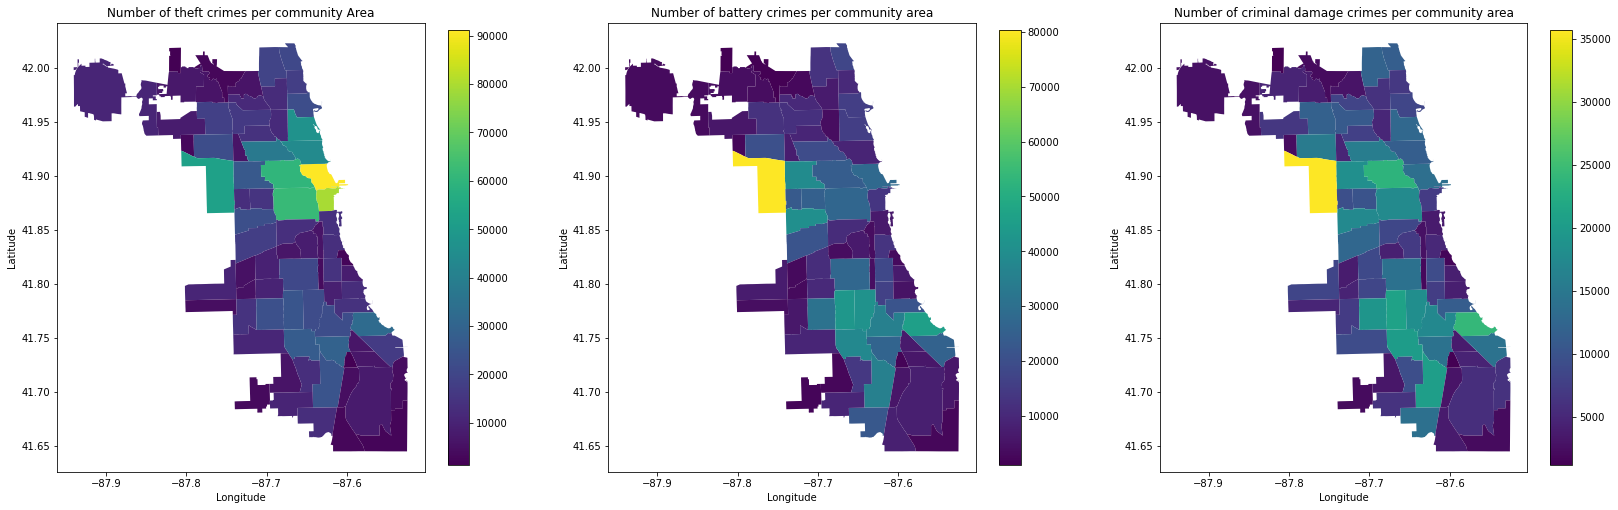

In [28]:
f, axes = plt.subplots(figsize=(28, 20), ncols=3, nrows=1)
titles = {
    1: 'Number of theft crimes per community Area',
    2: 'Number of battery crimes per community area',
    3: 'Number of criminal damage crimes per community area'
}
crimes = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE']
for i in range(3):
    crime_geodata = get_geo_data_for_crime(crimes[i])
    axes[i].set_title(titles[i + 1])
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    crime_geodata.plot(column='Count', ax=axes[i], legend=True, legend_kwds={'shrink': 0.4})
#plt.savefig('crimes_heatmap.png', dpi=100)

## Can we predict if an arrest was made for a crime? 

The last question we want to answer is whether we can predict if an arrest was made for a particular crime, based on given data.  
Note: In this project I have conducated a very basic approach of a logistic regression due to time constraints and scope of the overall project. A real project, aiming at useable results would spend more time on feature engineering and combination with other available data to obtain the best results.

First we get an overview about the different crime types in the dataset

In [29]:
df.groupby('Primary Type').size().sort_values(ascending=False)

Primary Type
THEFT                                1333568
BATTERY                              1141832
CRIMINAL DAMAGE                       714741
NARCOTICS                             633658
ASSAULT                               397038
OTHER OFFENSE                         388185
BURGLARY                              356346
MOTOR VEHICLE THEFT                   281848
DECEPTIVE PRACTICE                    277230
ROBBERY                               235820
CRIMINAL TRESPASS                     178106
WEAPONS VIOLATION                      77597
PROSTITUTION                           56938
OFFENSE INVOLVING CHILDREN             46002
PUBLIC PEACE VIOLATION                 45564
CRIM SEXUAL ASSAULT                    24224
SEX OFFENSE                            23468
INTERFERENCE WITH PUBLIC OFFICER       16732
GAMBLING                               12689
LIQUOR LAW VIOLATION                   11408
ARSON                                  10127
HOMICIDE                                95

In [30]:
arrest_data = df[['Primary Type', 'Arrest', 'Domestic', 'Community Area', 'Year', 'Month', 'Weekday', 'Hour']].copy()
arrest_data.head()

,Primary Type,Arrest,Domestic,Community Area,Year,Month,Weekday,Hour
0,BATTERY,False,True,61,2015,9,5,13
1,THEFT,False,False,25,2015,9,4,11
2,THEFT,False,True,44,2018,9,5,0
3,NARCOTICS,True,False,21,2015,9,5,12
4,ASSAULT,False,True,25,2015,9,5,13


Let's check how many crimes resulted in an arrest

In [31]:
arrest_data['Arrest'].value_counts(normalize=True)

False    0.731583
True     0.268417
Name: Arrest, dtype: float64

I've tried different solver algorithms for the model training and when using too many primary types, the algorithms did not converge, even after an increased number of iterations.  
Therefore, I've somewhat arbitrarily decided to only include crimes which have at least 100,000 records, as it showed to converge with enough iterations.

In [32]:
crime_types = arrest_data['Primary Type'].value_counts().loc[lambda x: x >= 100000].index.tolist()
arrest_data.drop(arrest_data[~arrest_data['Primary Type'].isin(crime_types)].index, inplace=True)

In [33]:
arrest_data['Primary Type'] = arrest_data['Primary Type'].cat.remove_unused_categories()

Since *Primary Type* is categorical data we create a dummy variable for each crime type.

In [34]:
arrest_data = pd.get_dummies(arrest_data, columns=['Primary Type'])
arrest_data.head()

,Arrest,Domestic,Community Area,Year,Month,Weekday,Hour,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_MOTOR VEHICLE THEFT,Primary Type_NARCOTICS,Primary Type_OTHER OFFENSE,Primary Type_ROBBERY,Primary Type_THEFT
0,False,True,61,2015,9,5,13,0,1,0,0,0,0,0,0,0,0,0
1,False,False,25,2015,9,4,11,0,0,0,0,0,0,0,0,0,0,1
2,False,True,44,2018,9,5,0,0,0,0,0,0,0,0,0,0,0,1
3,True,False,21,2015,9,5,12,0,0,0,0,0,0,0,1,0,0,0
4,False,True,25,2015,9,5,13,1,0,0,0,0,0,0,0,0,0,0


Because of the binary nature of the target variable (arrest vs. no arrest) I went with the approach of a logistic regression.  
To increase the chances that the solver algorithm converges, we set the *max_iter* paramter to 300

In [35]:
model = LogisticRegression(random_state=1, max_iter=300)

We split the data in train and test data in a 70% training, 30% testing

In [36]:
y = arrest_data['Arrest']
X = arrest_data.drop(['Arrest'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [37]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=300, random_state=1)

# Evaluate the Results

In [38]:
y_pred = model.predict(X_test)
print('Accuracy on test data: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy on test data: 0.87


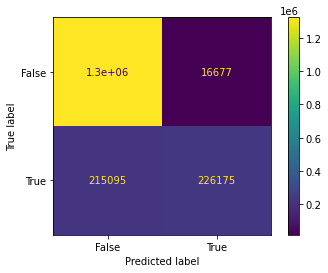

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
#plt.show()
plt.savefig('predictions_confusion_matrix.png', dpi=100)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.99      0.92   1340242
        True       0.93      0.51      0.66    441270

    accuracy                           0.87   1781512
   macro avg       0.90      0.75      0.79   1781512
weighted avg       0.88      0.87      0.86   1781512



## Summary
Since about 73% of crimes did not result in an arrest, it is relatively easy to achieve a good accuracy score.  
Upon closer inspection of other metrics, we see that this simple approach is not very useful for actual usage, as we predict only about half of the actual arrests correctly (recall value of 0.51).